In [ ]:
!pip install -qU PyMuPDF pdf2image datasets transformers evaluate
!apt-get install poppler-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [149]:
import os
import io
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm


import pymupdf as pdf
from pdf2image import convert_from_path

import evaluate
from datasets import Dataset, DatasetDict, Features
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Project Competitions/Parspec Assignment')

# Data preparation

In [ ]:
!ls

Assignment.ipynb  data	test.pdf


In [ ]:
train_df = pd.read_excel('data/mle-1-assign-dataset.xlsx', sheet_name='train_data')

In [ ]:
test_df = pd.read_excel('data/mle-1-assign-dataset.xlsx', sheet_name='test_data')

In [ ]:
train_df.head()

,datasheet_link,target_col
0,https://lfillumination.com/files/specsheets/EF...,lighting
1,https://lfillumination.com/files/specsheets/EF...,lighting
2,https://lfillumination.com/files/specsheets/EF...,lighting
3,https://www.waclighting.com/storage/waclightin...,lighting
4,https://www.acuitybrands.com/api/products/geta...,lighting


In [ ]:
train_df.isna().sum()

,0
datasheet_link,0
target_col,0


## Download PDFs through link

In [ ]:
os.makedirs('data/pdfs', exist_ok=True)

In [ ]:
def download_pdf(url, directory, filename):
    if not url.startswith('http'):
        print(f"Skipping invalid URL: {url}")
        return None

    if os.path.exists(os.path.join(directory, filename)):
        return filename

    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
            'Referer': 'https://www.google.com/',
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an exception for bad status codes
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

    # if response.headers.get('content-type', '').lower() != 'application/pdf':
    #     print(f"Warning: {url} does not appear to be a PDF")

    # Create full path
    filepath = os.path.join(directory, filename)

    # Write content to file
    with open(filepath, 'wb') as f:
        f.write(response.content)

    return filename

In [ ]:
# Download PDFs and update dataframe
train_df['filename'] = df.progress_apply(lambda row: download_pdf(
    row['datasheet_link'],
    'data/pdfs',
    f"{row['target_col']}_{row.name}.pdf"
), axis=1)

  0%|          | 0/1895 [00:00<?, ?it/s]

Error downloading https://lfillumination.com/files/specsheets/EF411B.PDF: 404 Client Error: Not Found for url: https://lfillumination.com/files/specsheets/EF411B.PDF


  0%|          | 7/1895 [00:00<01:30, 20.93it/s]

Error downloading https://www.acuitybrands.com/api/products/getasset/holophane/1649332/4408a251-09be-4b61-813f-177b3ebcf10c/holophane-care222-hldmpc-cylinder-pendant-with-cord.pdf?abl_version=01%2f12%2f2023+16%3a54%3a24&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://www.acuitybrands.com/api/products/getasset/holophane/1649332/4408a251-09be-4b61-813f-177b3ebcf10c/holophane-care222-hldmpc-cylinder-pendant-with-cord.pdf?abl_version=01%2F12%2F2023+16%3A54%3A24&DOC_Type=SPEC_SHEET


  1%|          | 22/1895 [00:03<04:55,  6.33it/s]

Error downloading https://beghelliusa.com/wp-content/uploads/2022/05/testa_spec.pdf: 404 Client Error: Not Found for url: https://beghelliusa.com/wp-content/uploads/2023/08/testa_spec.pdf


  4%|▎         | 69/1895 [00:04<01:44, 17.40it/s]

Error downloading https://beghelliusa.com/wp-content/uploads/2022/06/mpl-spec-15-280w_combined.pdf: 404 Client Error: Not Found for url: https://beghelliusa.com/wp-content/uploads/2022/06/mpl-spec-15-280w_combined.pdf


  6%|▌         | 107/1895 [00:05<00:59, 29.91it/s]

Error downloading https://lithonia.acuitybrands.com/api/products/getasset/lithonia-lighting/47332/28a353c1-2a40-4bec-81c0-2083787604bf/msfl.pdf?abl_version=10%2f04%2f2022+22%3a57%3a52&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://lithonia.acuitybrands.com/api/products/getasset/lithonia-lighting/47332/28a353c1-2a40-4bec-81c0-2083787604bf/msfl.pdf?abl_version=10%2F04%2F2022+22%3A57%3A52&DOC_Type=SPEC_SHEET
Error downloading https://www.axislighting.com/application/files/1816/6967/0425/Graze_Perfekt-Perimeter-Recessed.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1816/6967/0425/Graze_Perfekt-Perimeter-Recessed.SPEC.pdf


  6%|▌         | 118/1895 [00:05<01:02, 28.65it/s]

Error downloading https://www.contechlighting.com/en/docs/CLB_0720.pdf: 404 Client Error: Not Found for url: https://contechlighting.com/en/docs/CLB_0720.pdf
Error downloading https://www.lsicorp.com/wp-content/uploads/2020/05/augustaaud-aupleddatasheet.pdf: 404 Client Error: Not Found for url: https://www.lsicorp.com/wp-content/uploads/2020/05/augustaaud-aupleddatasheet.pdf


  7%|▋         | 125/1895 [00:05<01:11, 24.91it/s]

Error downloading https://www.lsicorp.com/wp-content/uploads/documents/products/constitution-xcn4-specsheet.pdf: 404 Client Error: Not Found for url: https://www.lsicorp.com/wp-content/uploads/documents/products/constitution-xcn4-specsheet.pdf
Error downloading https://www.axislighting.com/application/files/1216/7786/1717/EDGE2-Wall.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1216/7786/1717/EDGE2-Wall.SPEC.pdf


  8%|▊         | 161/1895 [00:06<00:41, 42.03it/s]

Error downloading https://www.contechlighting.com/en/docs/AW_SERIES_2022.pdf: 404 Client Error: Not Found for url: https://contechlighting.com/en/docs/AW_SERIES_2022.pdf


 10%|▉         | 187/1895 [00:07<00:43, 39.07it/s]

Error downloading https://www.intenselighting.com/en/docs/IL_MXG2PSD_WD.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSD_WD.pdf
Error downloading https://www.intenselighting.com/en/docs/IL_MXG2PSW.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSW.pdf
Error downloading https://www.intenselighting.com/en/docs/IL_MXG2PSW_WD.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2PSW_WD.pdf


 11%|█         | 211/1895 [00:08<00:50, 33.20it/s]

Error downloading https://www.intenselighting.com/en/docs/IL_SC8DRREM.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_SC8DRREM.pdf


 12%|█▏        | 225/1895 [00:08<00:49, 33.41it/s]

Error downloading https://juno.acuitybrands.com/api/products/getasset/juno/1777018/0517f67e-33eb-4973-a114-1b2563aaa4b0/jfx.pdf?abl_version=03%2f14%2f2023+18%3a11%3a50&DOC_Type=SPEC_SHEET: 404 Client Error: Not Found for url: https://juno.acuitybrands.com/api/products/getasset/juno/1777018/0517f67e-33eb-4973-a114-1b2563aaa4b0/jfx.pdf?abl_version=03%2F14%2F2023+18%3A11%3A50&DOC_Type=SPEC_SHEET


 12%|█▏        | 232/1895 [00:11<02:25, 11.44it/s]

Error downloading https://www.kelvix.com/product/signwave-3/spec-sheet/: 404 Client Error: Not Found for url: https://www.kelvix.com/product/signwave-3/spec-sheet/


 13%|█▎        | 237/1895 [00:14<04:00,  6.88it/s]

Error downloading https://www.kelvix.com/product/brett-502/spec-sheet/: 404 Client Error: Not Found for url: https://www.kelvix.com/product/brett-502/spec-sheet/


 13%|█▎        | 246/1895 [00:14<03:38,  7.54it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS09.pdf?d=8292022114811: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_EXT_VERS09.pdf?d=8292022114811
Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_EXT_VERS08.pdf?d=88202230058: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_EXT_VERS08.pdf?d=88202230058
Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WURM-RGBW.pdf?d=34202282606: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-WURM-RGBW.pdf?d=34202282606


 13%|█▎        | 249/1895 [00:16<04:38,  5.90it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-KURV-BK-SC.pdf?d=5202022124454: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-KURV-BK-SC.pdf?d=5202022124454
Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_EMBD-FLAT.pdf?d=125202312226: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_EMBD-FLAT.pdf?d=125202312226


 13%|█▎        | 251/1895 [00:17<05:36,  4.88it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ATOM-FLAT.pdf?d=8172021104924: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ATOM-FLAT.pdf?d=8172021104924
Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ALTA-FLAT.pdf?d=331202211843: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ALTA-FLAT.pdf?d=331202211843


 13%|█▎        | 253/1895 [00:18<06:39,  4.11it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_ARKA-FLAT.pdf?d=524202220601: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_ARKA-FLAT.pdf?d=524202220601


 13%|█▎        | 255/1895 [00:18<06:34,  4.15it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_THIN.pdf?d=1220202281306: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_THIN.pdf?d=1220202281306


 14%|█▎        | 256/1895 [00:19<07:09,  3.82it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD_FXT_TORQ-FLAT.pdf?d=524202221453: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD_FXT_TORQ-FLAT.pdf?d=524202221453


 14%|█▎        | 257/1895 [00:19<07:58,  3.43it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-NEXUS-SW.pdf?d=816202150937: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-NEXUS-SW.pdf?d=816202150937


 14%|█▎        | 258/1895 [00:20<08:47,  3.10it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-LUME-01-SC.pdf?d=1122202192218: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-LUME-01-SC.pdf?d=1122202192218


 14%|█▎        | 259/1895 [00:20<09:31,  2.86it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-RGB.pdf?d=119202211904: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-RGB.pdf?d=119202211904


 14%|█▎        | 260/1895 [00:21<10:18,  2.64it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-WALA-SW.pdf?d=816202151258: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-WALA-SW.pdf?d=816202151258


 14%|█▍        | 261/1895 [00:21<11:45,  2.31it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-SW.pdf?d=119202211634: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ANYBEND-SW.pdf?d=119202211634


 14%|█▍        | 262/1895 [00:22<12:25,  2.19it/s]

Error downloading https://www.q-tran.com/Customer-Content/www/products/Files/ORD-FXT-ZALA-SC.pdf?d=4222022123202: 404 Client Error: Not Found for url: https://www.qtl.lighting/Customer-Content/www/products/Files/ORD-FXT-ZALA-SC.pdf?d=4222022123202


 15%|█▍        | 284/1895 [00:22<01:48, 14.89it/s]

Error downloading https://www.intenselighting.com/en/docs/IL_MXG2ASTL_BEAM-Adjustable.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2ASTL_BEAM-Adjustable.pdf


 20%|██        | 386/1895 [00:23<00:14, 101.58it/s]

Error downloading https://www.intenselighting.com/en/docs/IL_MXG2DSTL_BEAM-Downlight.pdf: 404 Client Error: Not Found for url: https://intenselighting.com/en/docs/IL_MXG2DSTL_BEAM-Downlight.pdf
Error downloading https://www.axislighting.com/application/files/3116/7778/0070/Stencil-Flex-TDHDP.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/3116/7778/0070/Stencil-Flex-TDHDP.SPEC.pdf
Error downloading https://www.axislighting.com/application/files/1016/6491/5004/B2SQD.LED.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1016/6491/5004/B2SQD.LED.SPEC.pdf
Error downloading https://www.axislighting.com/application/files/8516/5712/4018/Stencil-Pendant-Forms-Combined.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/8516/5712/4018/Stencil-Pendant-Forms-Combined.SPEC.pdf


 22%|██▏       | 416/1895 [00:23<00:16, 87.64it/s] 

Error downloading https://www.waclighting.com/product/strut-56/?download=specs2&1676620206: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-56/?download=specs2&1676620206
Error downloading https://www.waclighting.com/product/strut-57/?download=specs2&1676620195: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-57/?download=specs2&1676620195
Error downloading https://www.waclighting.com/product/strut-55/?download=specs2&1676620218: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-55/?download=specs2&1676620218
Error downloading https://www.waclighting.com/product/strut-54/?download=specs2&1676620230: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-54/?download=specs2&1676620230


 23%|██▎       | 437/1895 [00:25<00:37, 38.88it/s]

Error downloading https://www.waclighting.com/product/strut-58/?download=specs2&1676620183: 404 Client Error: Not Found for url: https://www.waclighting.com/product/strut-58/?download=specs2&1676620183
Error downloading https://www.axislighting.com/application/files/1016/7811/8258/B6R.ASY.LED-B3.SPEC.pdf: 403 Client Error: Forbidden for url: https://www.axislighting.com/application/files/1016/7811/8258/B6R.ASY.LED-B3.SPEC.pdf


 31%|███       | 578/1895 [00:35<01:15, 17.46it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-0603fa-fast-acting-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 31%|███       | 585/1895 [00:45<02:37,  8.32it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-0603fa-fast-acting-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 32%|███▏      | 608/1895 [00:55<03:47,  5.66it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-gma-time-delay-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 35%|███▌      | 664/1895 [01:05<03:38,  5.62it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-gma-time-delay-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 35%|███▌      | 667/1895 [01:16<05:30,  3.72it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-agc-fast-acting-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 36%|███▌      | 676/1895 [01:26<07:19,  2.77it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 36%|███▌      | 679/1895 [01:36<10:19,  1.96it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-cb61f-surface-mount-brick-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 36%|███▌      | 681/1895 [01:46<14:22,  1.41it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 37%|███▋      | 693/1895 [01:56<15:01,  1.33it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 38%|███▊      | 729/1895 [02:06<09:37,  2.02it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 39%|███▉      | 738/1895 [02:16<11:35,  1.66it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 40%|███▉      | 756/1895 [02:27<11:09,  1.70it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216ff-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 41%|████      | 768/1895 [02:37<12:09,  1.54it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-cb61f-surface-mount-brick-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 42%|████▏     | 787/1895 [02:47<11:12,  1.65it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 42%|████▏     | 799/1895 [02:57<12:08,  1.50it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2292/438A_Series.pdf


 44%|████▍     | 840/1895 [03:07<07:44,  2.27it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-s505h-vac-time-delay-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 45%|████▍     | 847/1895 [03:17<09:45,  1.79it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-mda-time-delay-ceramic-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 45%|████▍     | 849/1895 [03:27<13:15,  1.32it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-s505h-vac-time-delay-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 45%|████▍     | 851/1895 [03:38<17:49,  1.02s/it]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216td-time-delay-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 45%|████▌     | 861/1895 [03:48<17:33,  1.02s/it]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-3216td-time-delay-chip-surface-mount-fuse-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 46%|████▌     | 864/1895 [03:58<22:12,  1.29s/it]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-mda-time-delay-ceramic-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1147/356_Series.pdf


 49%|████▉     | 925/1895 [04:08<06:52,  2.35it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-pc-tron-subminiature-radial-leaded-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 49%|████▉     | 928/1895 [04:18<09:17,  1.73it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-pc-tron-subminiature-radial-leaded-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 49%|████▉     | 937/1895 [04:28<10:45,  1.48it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-gma-time-delay-glass-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 50%|████▉     | 941/1895 [04:38<13:46,  1.15it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/data-sheet/eaton-mda-time-delay-ceramic-tube-fuses-data-sheet.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 51%|█████     | 962/1895 [04:48<10:51,  1.43it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/product-aid/eaton-1025hc-fuse-product-aid.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 51%|█████     | 963/1895 [04:59<15:05,  1.03it/s]

Error downloading https://www.eaton.com/content/dam/eaton/products/electronic-components/resources/product-aid/eaton-1025hc-fuse-product-aid.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1086/463_Series.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/45/885_Series_Fuse.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/45/885_Series_Fuse.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/45/885_Series_Fuse.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1086/463_Series.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1086/463_Series.pdf


 54%|█████▍    | 1023/1895 [05:03<04:45,  3.06it/s]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-300.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-300-datasheet.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2153/9272_Series%28in%29.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2250/1000671047_Ds.pdf


 55%|█████▍    | 1038/1895 [05:03<03:47,  3.77it/s]

Error downloading https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A5314&DocType=Customer+Drawing&DocLang=English: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A5314&DocType=Customer+Drawing&DocLang=English
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/695/086SC-2401_Ds.pdf


 56%|█████▌    | 1060/1895 [05:03<02:41,  5.17it/s]

Error downloading https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1: 404 Client Error: Not Found for url: https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2430/Coaxial%20Cable%20Systems%20non-plenum.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/4810/C1156.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1062/C1178.21.01.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/13/50CX-42.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/13/50CX-41.pdf


 57%|█████▋    | 1089/1895 [05:04<01:42,  7.89it/s]

Error downloading https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2143/1000671086_Ds.pdf


 58%|█████▊    | 1105/1895 [05:04<01:21,  9.67it/s]

Error downloading https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1: 404 Client Error: Not Found for url: https://literature.hubersuhner.com/Technologies/Radiofrequency/MicrowavecabelesEN/?gotofirstsearchresult=MINIBEND%20R-2.5&page=1


 59%|█████▉    | 1123/1895 [05:08<01:40,  7.65it/s]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-500.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-500-datasheet.pdf
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2250/1000671141_Ds.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/533/141SC-1901.pdf


 61%|██████    | 1147/1895 [05:15<02:16,  5.49it/s]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-LW195.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-lw195-datasheet-1.pdf
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/6223/89272.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/6155/LMR-400-LLPX.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/6155/TCOM-600.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_202620.tmp.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_745663.tmp.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_190554.tmp.pdf
Skipping invalid URL: -
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp

 65%|██████▍   | 1228/1895 [05:15<00:48, 13.87it/s]

Error downloading https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5022A1311&DocType=Customer+Drawing&DocLang=English: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=5022A1311&DocType=Customer+Drawing&DocLang=English
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_745663.tmp.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_190554.tmp.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_447906.tmp.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/3928/A28CF.pdf
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/4243/A28SS.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5731/tmp_485378.tmp.pdf
Skipping invalid URL: //mm.digik

 79%|███████▉  | 1502/1895 [05:16<00:07, 49.74it/s]

Error downloading https://www.adels-contact.com/pdf351101.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351101.pdf
Error downloading https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en: 500 Server Error:  for url: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en
Error downloading https://www.adels-contact.com/pdf351102.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351102.pdf


 80%|████████  | 1522/1895 [05:17<00:09, 40.46it/s]

Error downloading https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en: 500 Server Error:  for url: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1704853.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1704858.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1704857.pdf
Error downloading https://www.adels-contact.com/pdf151585.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151585.pdf


 81%|████████  | 1536/1895 [05:18<00:10, 35.58it/s]

Error downloading https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en: 500 Server Error:  for url: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1814867.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814647.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815280.pdf


 82%|████████▏ | 1553/1895 [05:19<00:09, 34.85it/s]

Error downloading https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en: 500 Server Error:  for url: https://www.hirose.com/product/document?clcode=CL0667-0028-7-21&productname=DF59SN-1P-FC(21)&series=DF59S__DF59SN&documenttype=Catalog&lang=en&documentid=D31625_en
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf


 82%|████████▏ | 1561/1895 [05:19<00:09, 34.67it/s]

Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/028-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/028-000&lang=en
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2472/DF59 Brochure.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815303.pdf


 83%|████████▎ | 1568/1895 [05:20<00:10, 31.29it/s]

Error downloading https://www.adels-contact.com/pdf151582.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151582.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815293.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1165/1830142.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1704854.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1028/1778722.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2472/DF59 Brochure.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/905/1778735.pdf


 84%|████████▎ | 1586/1895 [05:20<00:09, 32.28it/s]

Error downloading https://www.adels-contact.com/pdf151183.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151183.pdf
Error downloading https://www.adels-contact.com/pdf151485.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151485.pdf


 84%|████████▍ | 1600/1895 [05:21<00:11, 25.39it/s]

Error downloading https://www.adels-contact.com/pdf151465.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151465.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1704859.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-fls-sr40-01.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-fls-sr40-01.pdf
Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2065-133&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2065-133&lang=en


 86%|████████▌ | 1623/1895 [05:22<00:08, 31.61it/s]

Error downloading https://www.adels-contact.com/pdf351901.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351901.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1222/1840035.pdf
Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-901/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-901/021-000&lang=en
Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/030-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2060-952/030-000&lang=en
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bw

 86%|████████▋ | 1637/1895 [05:22<00:09, 27.83it/s]

Error downloading https://www.adels-contact.com/pdf351401.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351401.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/boardwiretoboard/bwb_rotaconnect_rotatable_btb.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1814883.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1777/1778706.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814676.pdf


 87%|████████▋ | 1650/1895 [05:23<00:09, 27.17it/s]

Error downloading https://www.adels-contact.com/pdf151482.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151482.pdf
Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-902/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-902/021-000&lang=en
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814744.pdf


 87%|████████▋ | 1655/1895 [05:23<00:09, 26.40it/s]

Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s21-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s21-xx.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814605.pdf


 88%|████████▊ | 1659/1895 [05:24<00:12, 19.56it/s]

Error downloading https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815316.pdf


 88%|████████▊ | 1662/1895 [05:24<00:15, 14.74it/s]

Error downloading https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/327/pdf160053.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814760.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p21-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p21-xx.pdf


 88%|████████▊ | 1667/1895 [05:25<00:18, 12.43it/s]

Error downloading https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p23-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p23-xx.pdf


 88%|████████▊ | 1671/1895 [05:25<00:20, 10.74it/s]

Error downloading https://www.adels-contact.com/pdf351402.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf351402.pdf
Error downloading https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-903/021-000&lang=en: 403 Client Error: Forbidden for url: https://www.wago.com/global/products/datasheets/Datasheet.pdf?product=2059-903/021-000&lang=en
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814553.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815329.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1814906.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/500/1814621.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815044.pdf


 89%|████████▉ | 1685/1895 [05:26<00:13, 15.44it/s]

Error downloading https://www.adels-contact.com/pdf151583.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf151583.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1814977.pdf


 89%|████████▉ | 1689/1895 [05:26<00:15, 13.35it/s]

Error downloading https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/665/1815251.pdf


 90%|████████▉ | 1699/1895 [05:27<00:12, 15.18it/s]

Error downloading https://www.adels-contact.com/pdf11630.pdf: 404 Client Error: Not Found for url: https://www.adels-contact.com/pdf11630.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p22-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-p22-xx.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s23-xx.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/drawing/p-flm-s23-xx.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/799/1830184.pdf
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: -
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/5337/P.S-I-81243-A.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/2469/CXA-0538-A Drawing.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220

100%|██████████| 1895/1895 [05:27<00:00,  5.78it/s]

Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/371/LXM1611-01.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1021/LXM1626-12-64.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/829/BXA-12379.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1018/BXA-12563.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/374/LXMG1621_rev07.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/374/lxmg1623-12-44.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/998/BXA-12665-5M.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/1073/LS380_RH.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/729/LS460_RH.pdf
Skipping invalid URL: //mm.digikey.com/Volume0/opasdata/d220001/medias/docus/921/LS530_RH.pdf
Skipping invalid URL: //mm.digik

In [ ]:
test_df['filename'] = test_df.progress_apply(lambda row: download_pdf(
    row['datasheet_link'],
    'data/pdfs',
    f"{row['target_col']}_{row.name}.pdf"
), axis=1)

 33%|███▎      | 133/400 [00:20<07:41,  1.73s/it]

Error downloading https://www.eaton.com/content/dam/eaton/products/electrical-circuit-protection/fuses/bussmann-series-supplemental-fuses/automotive-blade-type/bus-ele-ds-2009-atc.pdf: HTTPSConnectionPool(host='www.eaton.com', port=443): Read timed out. (read timeout=10)


 38%|███▊      | 154/400 [00:29<01:19,  3.09it/s]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 39%|███▉      | 157/400 [00:31<02:19,  1.75it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 40%|███▉      | 159/400 [00:31<01:48,  2.22it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 42%|████▏     | 167/400 [00:34<01:23,  2.77it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=109260: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=109260


 43%|████▎     | 172/400 [00:35<01:08,  3.35it/s]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 44%|████▎     | 174/400 [00:36<01:06,  3.40it/s]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 44%|████▍     | 178/400 [00:43<03:05,  1.19it/s]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 45%|████▌     | 180/400 [00:43<02:13,  1.64it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 45%|████▌     | 181/400 [00:44<02:09,  1.69it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 46%|████▌     | 183/400 [00:45<01:47,  2.01it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 48%|████▊     | 191/400 [00:48<01:00,  3.45it/s]

Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf


 57%|█████▋    | 227/400 [00:54<00:49,  3.46it/s]

Error downloading https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-us/component/skuAsset?mediaId=117459


 61%|██████    | 243/400 [01:10<03:07,  1.20s/it]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 61%|██████▏   | 245/400 [01:11<02:13,  1.16it/s]

Error downloading https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259: 404 Client Error: Not Found for url: https://www.essentracomponents.com/en-gb/component/skuAsset?mediaId=109259


 62%|██████▏   | 246/400 [01:11<02:10,  1.18it/s]

Error downloading https://www.essentracomponents.com.sg/images-line/pdfs/FMPT-92.pdf: 503 Server Error: Service Unavailable for url: https://www.essentracomponents.com.sg/images-line/pdfs/FMPT-92.pdf


 63%|██████▎   | 251/400 [01:14<01:07,  2.22it/s]

Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf
Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf


 63%|██████▎   | 253/400 [01:14<00:45,  3.25it/s]

Error downloading https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf: 403 Client Error: Forbidden for url: https://cdn.amphenol-cs.com/media/wysiwyg/files/documentation/datasheet/inputoutput/io_ctw_fan_module.pdf


 72%|███████▏  | 287/400 [01:46<02:35,  1.37s/it]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-240-UF.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-240-uf-datasheet.pdf


 78%|███████▊  | 310/400 [01:56<00:27,  3.28it/s]

Error downloading https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007: 500 Server Error: Internal Server Error for url: https://www.te.com/commerce/DocumentDelivery/DDEController?Action=srchrtrv&DocNm=7528A1317&DocType=Customer+Drawing&DocLang=English&PartCntxt=440063-007


 79%|███████▉  | 315/400 [01:58<00:37,  2.26it/s]

Error downloading https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf: 404 Client Error: Not Found for url: https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf


 80%|████████  | 321/400 [02:02<01:35,  1.20s/it]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-240-UF.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-240-uf-datasheet.pdf


 81%|████████  | 323/400 [02:06<02:03,  1.60s/it]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-240-UF.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-240-uf-datasheet.pdf


 87%|████████▋ | 347/400 [02:21<01:22,  1.56s/it]

Error downloading https://www.timesmicrowave.com/DataSheets/CableProducts/LMR-500.pdf: 404 Client Error: Not Found for url: https://timesmicrowave.com/wp-content/uploads/2022/06/lmr-500-datasheet.pdf


 89%|████████▉ | 356/400 [02:25<00:19,  2.21it/s]

Error downloading https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf: 404 Client Error: Not Found for url: https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf


 92%|█████████▏| 366/400 [02:29<00:13,  2.54it/s]

Error downloading https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf: 404 Client Error: Not Found for url: https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf


 97%|█████████▋| 387/400 [02:42<00:08,  1.55it/s]

Error downloading https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf: 404 Client Error: Not Found for url: https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf


 97%|█████████▋| 388/400 [02:43<00:07,  1.55it/s]

Error downloading https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf: 404 Client Error: Not Found for url: https://www.crystek.com/microwave/spec-sheets/bulkcable/CC-SS402.pdf


100%|██████████| 400/400 [02:50<00:00,  2.35it/s]


In [ ]:
train_df.to_csv("data/mapped_train_data.csv", index=False)

In [ ]:
test_df.to_csv("data/mapped_test_data.csv", index=False)

In [ ]:
!ls data/pdfs | wc -l

1560


around 50 mins (reran again with headers in case file is not download)

## Exploration

In [ ]:
train_df = pd.read_csv("data/mapped_train_data.csv")

In [ ]:
test_df = pd.read_csv("data/mapped_test_data.csv")

In [ ]:
train_df.head()

,datasheet_link,target_col,filename
0,https://lfillumination.com/files/specsheets/EF...,lighting,lighting_0.pdf
1,https://lfillumination.com/files/specsheets/EF...,lighting,NaN
2,https://lfillumination.com/files/specsheets/EF...,lighting,lighting_2.pdf
3,https://www.waclighting.com/storage/waclightin...,lighting,lighting_3.pdf
4,https://www.acuitybrands.com/api/products/geta...,lighting,lighting_4.pdf


In [ ]:
train_df.isna().sum()

,0
datasheet_link,0
target_col,0
filename,335


In [ ]:
test_df.isna().sum()

,0
datasheet_link,0
target_col,0
filename,30


In [ ]:
train_df[train_df.filename.isna()]

,datasheet_link,target_col,filename
1,https://lfillumination.com/files/specsheets/EF...,lighting,NaN
5,https://www.acuitybrands.com/api/products/geta...,lighting,NaN
20,https://beghelliusa.com/wp-content/uploads/202...,lighting,NaN
67,https://beghelliusa.com/wp-content/uploads/202...,lighting,NaN
83,https://lithonia.acuitybrands.com/api/products...,lighting,NaN
...,...,...,...
1883,//mm.digikey.com/Volume0/opasdata/d220001/medi...,others,NaN
1884,//mm.digikey.com/Volume0/opasdata/d220001/medi...,others,NaN
1885,//mm.digikey.com/Volume0/opasdata/d220001/medi...,others,NaN
1888,//mm.digikey.com/Volume0/opasdata/d220001/medi...,others,NaN


In [ ]:
train_df.dropna(inplace=True)

In [ ]:
test_df.dropna(inplace=True)

In [ ]:
train_df['target_col'].value_counts()

,count
target_col,
fuses,465
lighting,455
cable,405
others,235


In [ ]:
random_pdf = random.choice(os.listdir('data/pdfs'))
random_pdf

'fuses_528.pdf'

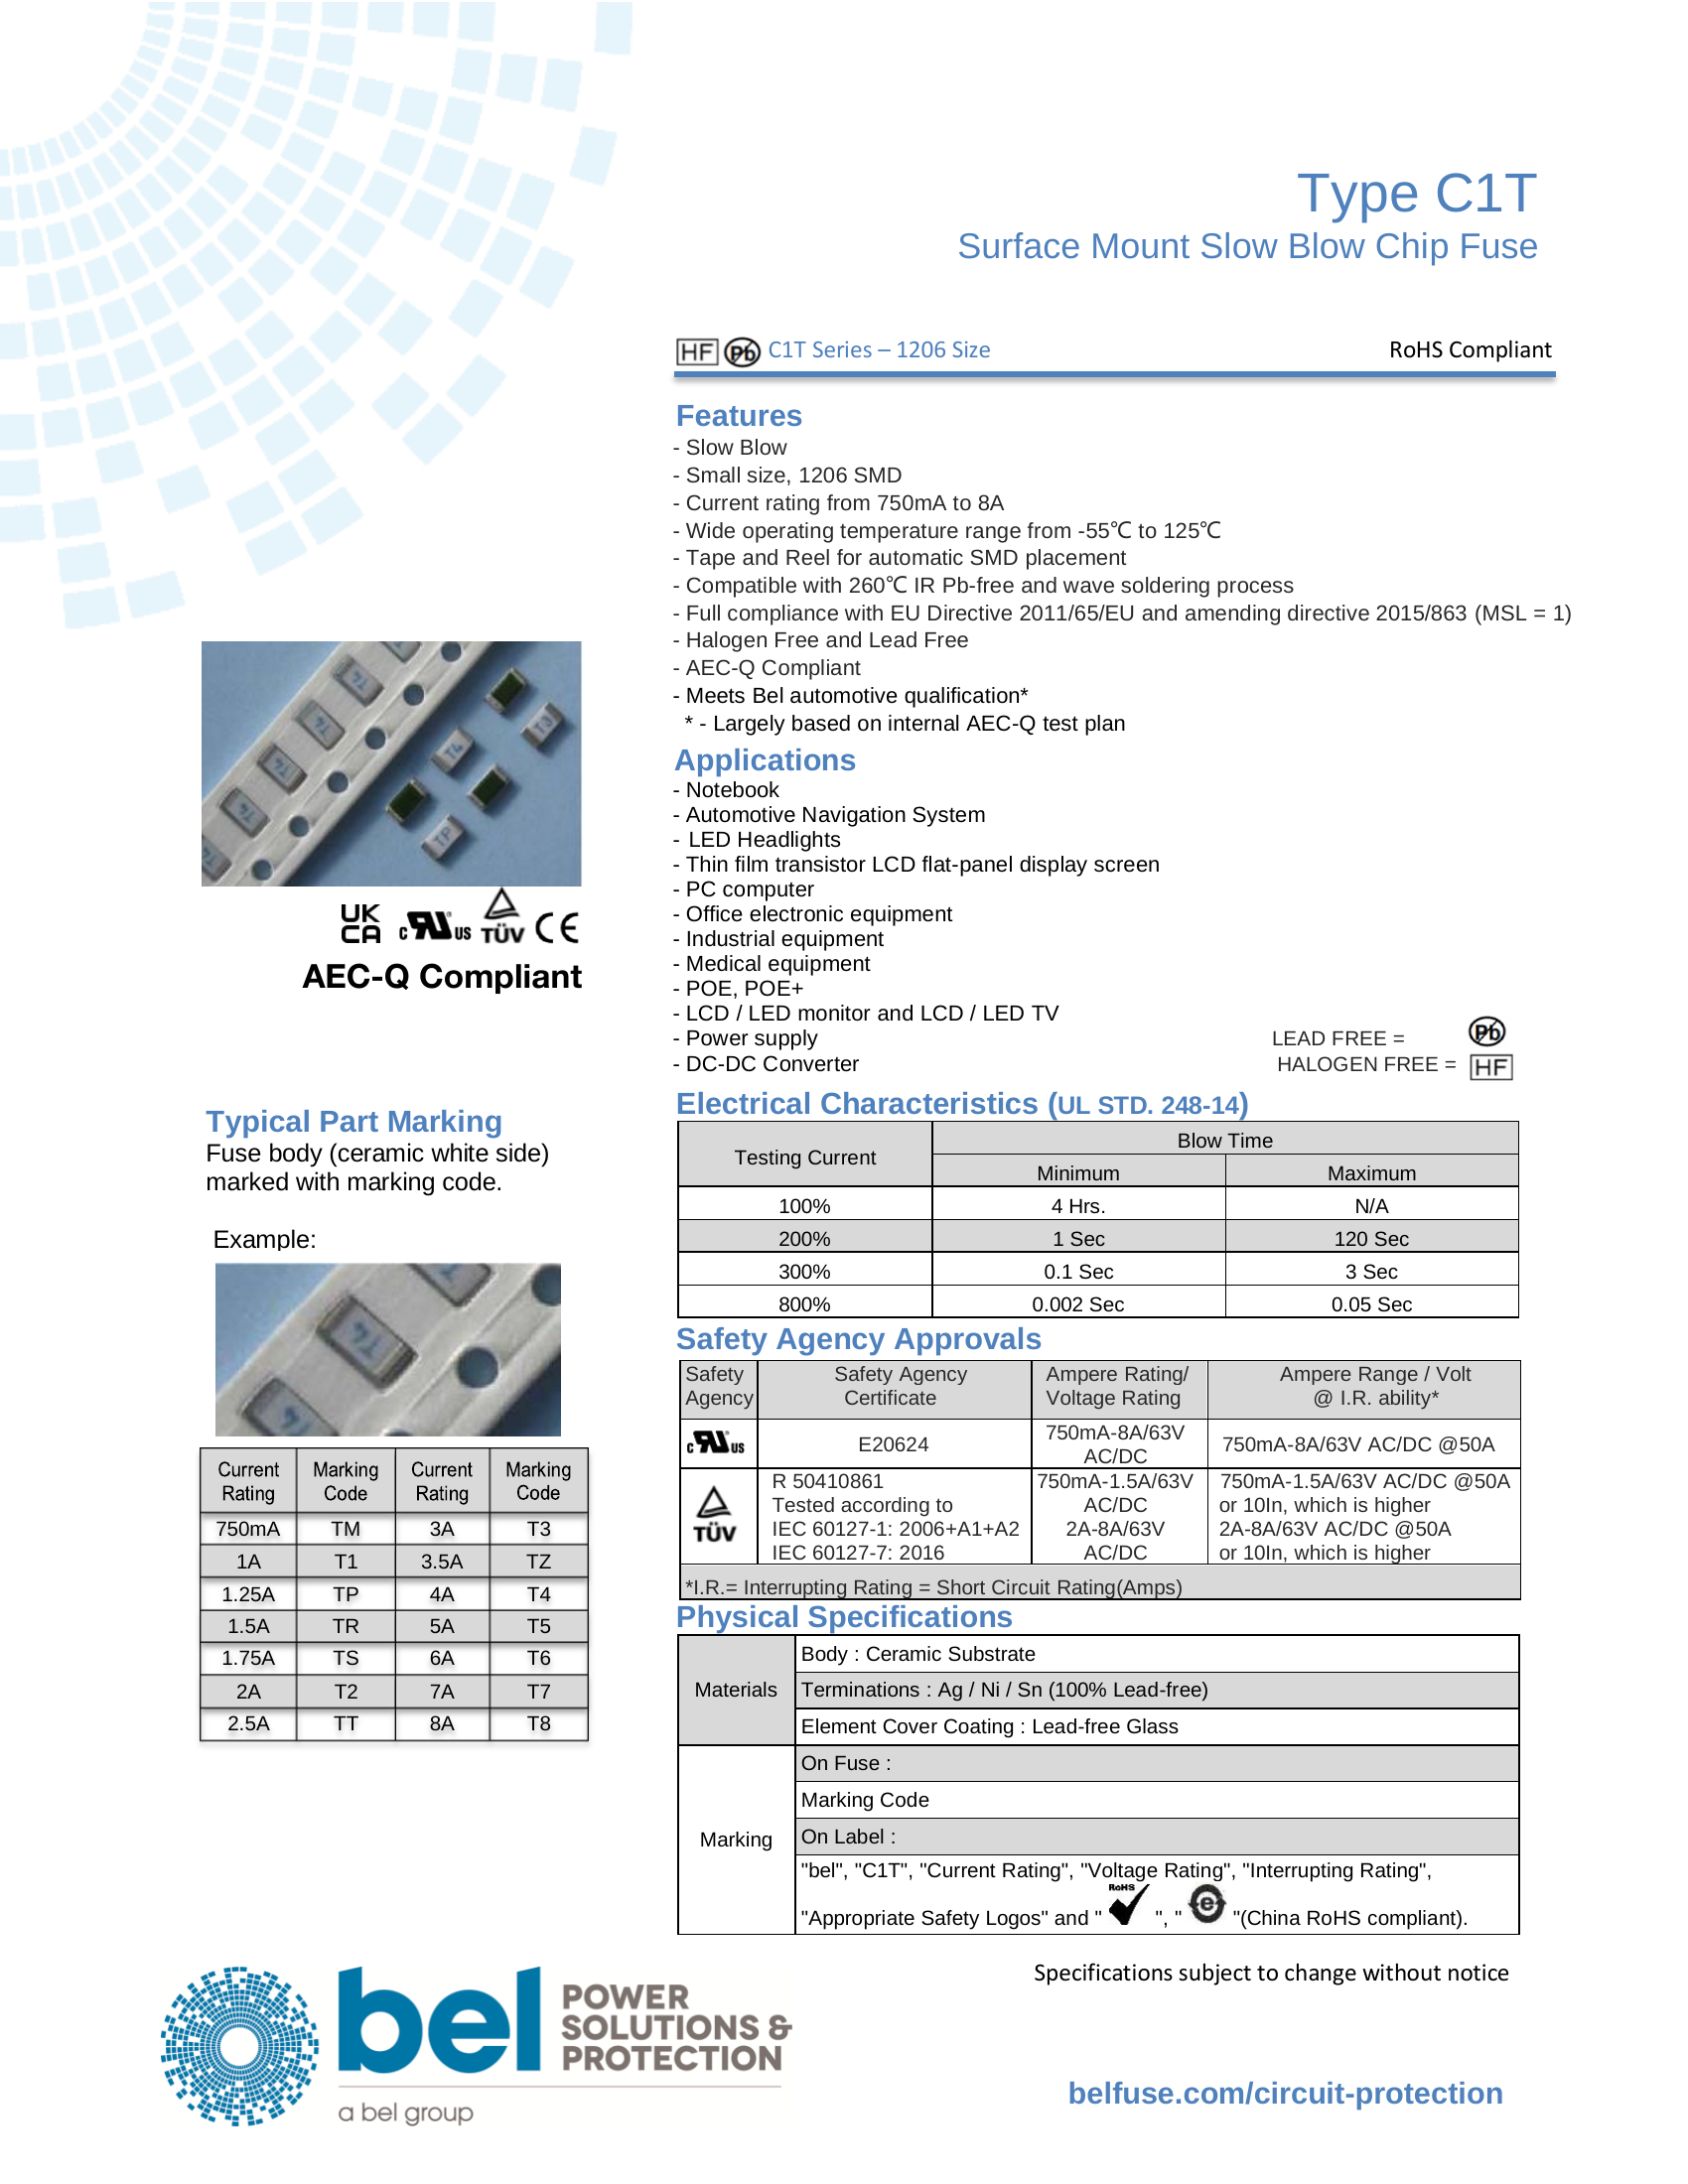

In [ ]:
random_pdf_path = os.path.join('data/pdfs', random_pdf)
images = convert_from_path(random_pdf_path)
images[0]

## Observation

1. Only the first page is consists of identifiable information
2. Although there are diagrams that represent the respective classes but lot of variation is present in the same thus going with visual features at start might not be that great
3. Similar kinda words are used for each category, e.g.
 - Lightening : Lens, Lumens, LED, etc.
 - Fuses: Fuse, Fuse Kit, etc.
 - Cable: Temperature Band, Cable, etc.  
 So going for text based solutions, lets say BERT seems appropriate

# Dataset Preparation

In [ ]:
PDF_DIR = 'data/pdfs'

In [ ]:
def extract_text_and_label(pdf_path):
  try:
    # Extract text using PyMuPDF
    doc = pdf.open(pdf_path)
    text = ""
    for page in doc:
    text += page.get_text()
    break

    # Extract label from filename
    label = os.path.splitext(os.path.basename(pdf_path))[0].split('_')[0].lower()
    return text, label
  except Exception as e:
    print(f"Error processing {pdf_path}")
    return None, None

In [ ]:
extract_text_and_label(random_pdf_path)

('Type C1T \nSurface Mount Slow Blow Chip Fuse \n \n \nbelfuse.com/circuit-protection \n \n \nC1T Series – 1206 Size                                                                       RoHS Compliant \nFeatures  \n- Slow Blow \n- Small size, 1206 SMD  \n- Current rating from 750mA to 8A \n- Wide operating temperature range from -55℃ to 125℃ \n- Tape and Reel for automatic SMD placement \n- Compatible with 260℃ IR Pb-free and wave soldering process  \n- Full compliance with EU Directive 2011/65/EU and amending directive 2015/863 (MSL = 1) \n- Halogen Free and Lead Free \n- AEC-Q Compliant  \n- Meets Bel automotive qualification* \n  * - Largely based on internal AEC-Q test plan  \n \nApplications   \n- Notebook \n- Automotive Navigation System \n- LED Headlights \n- Thin film transistor LCD flat-panel display screen \n- PC computer \n- Office electronic equipment \n- Industrial equipment \n- Medical equipment \n- POE, POE+ \n- LCD / LED monitor and LCD / LED TV \n- Power supply       

In [ ]:
data = []
for filename in tqdm(train_df['filename']):
  pdf_path = os.path.join(PDF_DIR, filename)
  text, label = extract_text_and_label(pdf_path)
  if text and label:
    data.append({'text': text, 'label': label})

  0%|          | 0/1560 [00:00<?, ?it/s]

Error processing data/pdfs/lighting_32.pdf
Error processing data/pdfs/lighting_35.pdf
Error processing data/pdfs/lighting_38.pdf
Error processing data/pdfs/lighting_65.pdf
Error processing data/pdfs/lighting_107.pdf
Error processing data/pdfs/lighting_125.pdf
Error processing data/pdfs/lighting_149.pdf
Error processing data/pdfs/lighting_150.pdf
Error processing data/pdfs/lighting_172.pdf
Error processing data/pdfs/lighting_181.pdf
Error processing data/pdfs/lighting_188.pdf
Error processing data/pdfs/lighting_194.pdf
Error processing data/pdfs/lighting_280.pdf
Error processing data/pdfs/lighting_437.pdf
Error processing data/pdfs/lighting_445.pdf
Error processing data/pdfs/lighting_455.pdf
Error processing data/pdfs/lighting_456.pdf
Error processing data/pdfs/lighting_457.pdf
Error processing data/pdfs/lighting_458.pdf
Error processing data/pdfs/lighting_462.pdf
Error processing data/pdfs/lighting_479.pdf
Error processing data/pdfs/fuses_584.pdf
Error processing data/pdfs/cable_1000.p

In [ ]:
# Create Hugging Face Dataset
train_hf_df = pd.DataFrame(data)
train_dataset = Dataset.from_pandas(train_hf_df)
train_dataset = train_dataset.class_encode_column("label")

Casting to class labels:   0%|          | 0/1259 [00:00<?, ? examples/s]

In [ ]:
train_dataset.features['label'].names

['cable', 'fuses', 'lighting', 'others']

In [ ]:
test_data = []
for filename in tqdm(test_df['filename']):
  pdf_path = os.path.join(PDF_DIR, filename)
  text, label = extract_text_and_label(pdf_path)
  if text and label:
    test_data.append({'text': text, 'label': label})

  0%|          | 0/370 [00:00<?, ?it/s]

Error processing data/pdfs/lighting_32.pdf
Error processing data/pdfs/lighting_35.pdf
Error processing data/pdfs/lighting_38.pdf
Error processing data/pdfs/lighting_65.pdf
Error processing data/pdfs/others_161.pdf
Error processing data/pdfs/others_163.pdf
Error processing data/pdfs/others_184.pdf
Error processing data/pdfs/others_187.pdf
Error processing data/pdfs/others_231.pdf
Error processing data/pdfs/others_236.pdf
Error processing data/pdfs/others_261.pdf
Error processing data/pdfs/others_266.pdf
Error processing data/pdfs/cable_278.pdf
Error processing data/pdfs/cable_286.pdf
Error processing data/pdfs/cable_297.pdf
Error processing data/pdfs/cable_300.pdf
Error processing data/pdfs/cable_301.pdf
Error processing data/pdfs/cable_342.pdf
Error processing data/pdfs/cable_349.pdf
Error processing data/pdfs/cable_355.pdf
Error processing data/pdfs/cable_373.pdf
Error processing data/pdfs/cable_381.pdf
Error processing data/pdfs/cable_389.pdf
Error processing data/pdfs/cable_391.pdf


In [ ]:
test_hf_df = pd.DataFrame(test_data)
test_dataset = Dataset.from_pandas(test_hf_df)
test_dataset = test_dataset.class_encode_column("label")

Casting to class labels:   0%|          | 0/335 [00:00<?, ? examples/s]

In [ ]:
assert test_dataset.features['label'].names == train_dataset.features['label'].names

In [ ]:
# dataset = train_dataset.train_test_split(test_size=0.1)
# not splitting since test data already given

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1259
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 335
    })
})


In [ ]:
dataset_dict.save_to_disk('data/parspec_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/1259 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/335 [00:00<?, ? examples/s]

In [ ]:
dataset_dict = DatasetDict.load_from_disk('data/parspec_dataset')

# Training

In [ ]:
!nvidia-smi

Thu Aug  8 21:42:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              33W /  70W |   8297MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Load pre-trained BERT tokenizer and model
model_name = "bert-base-uncased"  # You can choose a different BERT variant
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dataset["train"].features['label'].names))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

In [ ]:
# Tokenize the dataset
tokenized_datasets = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/1259 [00:00<?, ? examples/s]

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

In [ ]:
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

In [ ]:
def compute_metrics(preds):
    logits, labels = preds
    predictions = np.argmax(logits, axis=-1)

    precision = precision_metric.compute(predictions=predictions, references=labels,
                                average="micro")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels,
                             average="micro")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels,
                         average="micro")["f1"]

    return {"precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./model/",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    torch_compile=True,
    fp16=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.763600,0.636988,0.743284,0.743284,0.743284
2,0.098700,0.329632,0.853731,0.853731,0.853731
3,0.019900,0.240385,0.895522,0.895522,0.895522
4,0.008400,0.233861,0.901493,0.901493,0.901493
5,0.005700,0.163382,0.949254,0.949254,0.949254
6,0.004400,0.151240,0.949254,0.949254,0.949254
7,0.003800,0.143821,0.955224,0.955224,0.955224
8,0.003300,0.139351,0.955224,0.955224,0.955224
9,0.003100,0.137696,0.970149,0.970149,0.970149
10,0.002900,0.136757,0.970149,0.970149,0.970149


{'eval_loss': 0.13675737380981445,
 'eval_precision': 0.9701492537313433,
 'eval_recall': 0.9701492537313433,
 'eval_f1': 0.9701492537313433,
 'eval_runtime': 2.8104,
 'eval_samples_per_second': 119.2,
 'eval_steps_per_second': 3.914,
 'epoch': 10.0}

# Evaluation

In [126]:
predictions = trainer.predict(tokenized_datasets["test"])

In [147]:
labels = dataset_dict['train'].features['label'].names
y_true = [labels[i] for i in predictions[1]]
y_pred = [labels[i] for i in predictions[0].argmax(axis=1)]

In [152]:
# Compute the confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

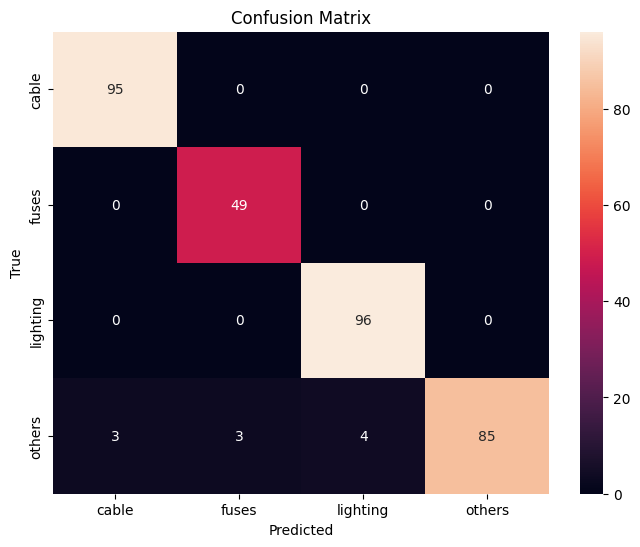

In [153]:
# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()